In [275]:
import os
from distutils.dir_util import copy_tree
import json
import glob
import math
import pickle
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 17,
    'font.size': 16,
    'ytick.labelsize': 15,
    'xtick.labelsize': 15,
})
from matplotlib.lines import Line2D
from functools import partial

import torch
import transformers
from datasets import load_from_disk

from weak_to_strong.datasets import (
    VALID_DATASETS,
    load_dataset,
    tokenize_dataset
)
from weak_to_strong.model import TransformerWithHead

COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]
COLOR_MAP = {
    None: "black",
    "gpt2": "tab:blue",
    "gpt2-medium": "tab:orange",
    "gpt2-large": "tab:green",
    "gpt2-xl": "tab:red",
}
MODELS_MAP = {
    "gpt2": "GPT-2",
    "gpt2-medium": "GPT-2 M",
    "gpt2-large": "GPT-2 L",
    "gpt2-xl": "GPT-2 XL",
}
METHOD_COLOR_MAP = {
    "ceil": "black",
    "nogt": COLORS[0],
    "boolq_uniform_wmconf": COLORS[1],
    "boolq_uniform_rand": COLORS[2],
    "boolq_weak_all_2_gt_smconf": COLORS[3],
    "boolq_weak_all_2_gt_smconf_lp": COLORS[4],
}
METHOD_LABEL_MAP = {
    "boolq_nogt": "No GT",
    "boolq_uniform_wmconf": "Mix (Conf)",
    "boolq_uniform_rand": "Mix (Rand)",
    "boolq_weak_all_2_gt_smconf": "2-stage",
    "boolq_weak_all_2_gt_smconf_lp": "2-stage (LP)",
}



def est_ci(xs):
    return sns.utils.ci(sns.algorithms.bootstrap(xs))


def bootstrap_ci(data, n_bootstraps=10000, ci_level=0.95):
    """
    Calculate the confidence interval using bootstrapping.

    Parameters:
    - data: list of floats
    - n_bootstraps: number of bootstrap samples (default: 10000)
    - ci_level: confidence level (default: 0.9)

    Returns:
    - mean: mean of the data
    - lower: lower limit of the confidence interval
    - upper: upper limit of the confidence interval
    """
    data = np.array(data)

    if len(data) == 1:
        return data[0], np.nan, np.nan

    n = len(data)

    bootstrap_means = []

    bootstrap_sample = np.random.choice(data, size=(n_bootstraps,n), replace=True)
    bootstrap_means = bootstrap_sample.mean(axis=1)

    mean = np.mean(bootstrap_means)

    alpha = 1 - ci_level
    lower = np.percentile(bootstrap_means, alpha/2 * 100)
    upper = np.percentile(bootstrap_means, (1 - alpha/2) * 100)

    return mean, lower, upper


def normal_ci(data, ci_level=0.95):
    lower = np.percentile(data, (1 - ci_level)/2 * 100)
    upper = np.percentile(data, (1 + ci_level)/2 * 100)
    return np.median(data), lower, upper


def get_results_from_folder(folder):
    results_path = os.path.join('results', folder)

    glob_str = os.path.join(results_path, "**/second/results_summary.json")
    if not glob.glob(glob_str):
        glob_str = os.path.join(results_path, "**/first/results_summary.json")

    records = []
    for result_filename in glob.glob(glob_str):
        config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
        config = json.load(open(config_file, "r"))
        if config["model_size"] not in MODELS_TO_PLOT:
            continue
        if 'seed' not in config:
            config['seed'] = 0
        record = config.copy()
        if 'weak_model' in config:
            for k in record['weak_model']:
                if k == 'model_size':
                    assert record['weak_model'][k] == record['weak_model_size']
                record['weak_' + k] = record['weak_model'][k]
            del record['weak_model']
        record.update(json.load(open(result_filename)))
        records.append(record)
    df = pd.DataFrame.from_records(records).sort_values(['ds_name', 'model_size'])
    return df


def get_data_from_folder(folder):
    results_path = os.path.join('results', folder)

    glob_str = os.path.join(results_path, "**/second/results_summary.json")
    if not glob.glob(glob_str):
        glob_str = os.path.join(results_path, "**/first/results_summary.json")

    records = []
    for result_filename in glob.glob(glob_str):
        config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
        config = json.load(open(config_file, "r"))

        record = {
            "seed": config["seed"],
            "model_size": config["model_size"],
        }
        if "weak_model_size" in config:
            record["weak_model_size"] = config["weak_model"]["model_size"]
        if "gt_ratio" in config:
            record["gt_ratio"] = config["gt_ratio"]
        record.update(json.load(open(result_filename)))
        records.append(record)
    return pd.DataFrame(records)

# Plotting

## Tuning

In [960]:
def get_data(folder):
    results_path = os.path.join('results', folder)

    glob_str = os.path.join(results_path, "**/second/results.pkl")
    if not glob.glob(glob_str):
        glob_str = os.path.join(results_path, "**/first/results.pkl")

    records = []
    for result_filename in glob.glob(glob_str, recursive=True):
        config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
        config = json.load(open(config_file, "r"))

        if "warmup_steps" not in config:
            config["warmup_steps"] = 0
        if "end_mult" not in config:
            config["end_mult"] = 0.0

        with open(result_filename, "rb") as f:
            results = pickle.load(f)

        data = config.copy()
        try:
            data["valid_acc"] = np.mean(results["test_results"]["acc"])
        except:
            import pdb;pdb.set_trace()
        data["test_acc"] = results["avg_acc_test"]
        records.append(data)
    return pd.DataFrame(records)

In [1008]:
folders = [
    # "boolq_weak_all_2_gt_smconf_sbs8_slm5",
    "boolq_weak_all_2_gt_smconf_sbs8_slm1",
    "boolq_weak_all_2_gt_smconf_sbs8_slm05",

    # "boolq_weak_all_2_gt_smconf_sbs16_slm5",
    "boolq_weak_all_2_gt_smconf_sbs16_slm1",
    "boolq_weak_all_2_gt_smconf_sbs16_slm07",

    "boolq_weak_all_2_gt_smconf_sbs32_slm1",
]

folders = [
    # "boolq_weak_all_2_gt_smconf_sbs16_slm1",

    "boolq_weak_all_2_gt_smconf_gr01_sbs16_slm1",
    "boolq_weak_all_2_gt_smconf_gr01_sbs8_slm1",
    "boolq_weak_all_2_gt_smconf_gr01_sbs8_slm05",
    "boolq_weak_all_2_gt_smconf_gr01_sbs8_slm01",
]
weak = "gpt2-large"
strongs = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]

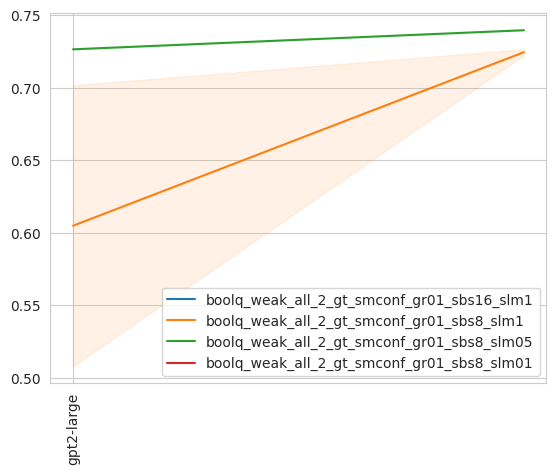

In [1009]:
plot_valid = False


fig, ax = plt.subplots(1, 1)

for i, folder in enumerate(folders):
    df = get_data(folder)

    if len(df) == 0:
        continue

    xtick_labels, means, lowers, uppers = [], [], [], []
    for sm in strongs:
        model_df = df[(df.model_size == sm) & (df.weak_model_size == weak)]

        if len(model_df) == 0:
            continue

        accs = model_df.valid_acc.values if plot_valid else model_df.test_acc.values
        lower, upper = est_ci(accs)

        xtick_labels.append(sm)
        means.append(np.mean(accs))
        uppers.append(upper)
        lowers.append(lower)

    means = np.array(means)
    lowers = np.array(lowers)
    uppers = np.array(uppers)

    ax.plot(np.arange(len(means)), means, label=folder, color=COLORS[i])
    ax.fill_between(np.arange(len(means)), lowers, uppers, color=COLORS[i], alpha=0.1)
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(xtick_labels, rotation=90)
ax.legend()

## Main Plots

In [466]:
# @title Bar Plots
def get_x_for_bar(idx, offset, bw, num_bars):
    return idx + (offset - num_bars / 2) * bw

def plot_test_acc_bars(results_df, gt_ratio, ceil_df, nogt_df):
    ratio_df = results_df[np.isclose(results_df.gt_ratio, gt_ratio)]

    methods = list(ratio_df.method.unique())
    num_methods = 2 + len(methods)
    bw = 1 / (num_methods + 1) # bar width
    capsize = 6.0

    fig, axes = plt.subplots(1, len(MODELS_TO_PLOT), figsize=(6 * 4, 4.5), width_ratios=(4, 3, 2, 1))

    for wm_idx, wm in enumerate(MODELS_TO_PLOT):
        wm_df = ratio_df[ratio_df.weak_model_size == wm]

        xtick_labels = []
        for sm_idx in range(wm_idx, len(MODELS_TO_PLOT)):
            sm = MODELS_TO_PLOT[sm_idx]

            df = wm_df[wm_df.model_size == sm]

            # Plot nogt.
            nogt_accs = nogt_df[(nogt_df.model_size == sm) & (nogt_df.weak_model_size == wm)].accuracy.values
            mean, lower, upper = bootstrap_ci(nogt_accs)
            axes[wm_idx].bar(x=get_x_for_bar(sm_idx - wm_idx, 0, bw, num_methods),
                            height=mean, width=bw, align='edge',
                            yerr=[[mean - lower], [upper - mean]],
                            error_kw=dict(capsize=capsize, capthick=1.0),
                            label="No GT", color=METHOD_COLOR_MAP["nogt"])

            # Plot methods.
            for idx, method in enumerate(methods):
                method_df = df[df.method == method]
                if len(method_df) == 0:
                    continue
                method_accs = method_df.accuracy.values
                mean, lower, upper = bootstrap_ci(method_accs)
                axes[wm_idx].bar(x=get_x_for_bar(sm_idx - wm_idx, idx + 1, bw, num_methods),
                                height=mean, width=bw, align='edge',
                                yerr=[[mean - lower], [upper - mean]],
                                error_kw=dict(capsize=capsize, capthick=1.0),
                                label=METHOD_LABEL_MAP[method], color=METHOD_COLOR_MAP[method])

            # Plot ceil.
            ceil_accs = ceil_df[(ceil_df.model_size == sm)].accuracy.values
            mean, lower, upper = bootstrap_ci(ceil_accs)
            axes[wm_idx].bar(x=get_x_for_bar(sm_idx - wm_idx, num_methods - 1, bw, num_methods),
                            height=mean, width=bw, align='edge',
                            yerr=[[mean - lower], [upper - mean]],
                            error_kw=dict(capsize=capsize, capthick=1.0),
                            label="GT", color=METHOD_COLOR_MAP["ceil"])

            # xtick_labels.append(f"{MODELS_MAP[wm]} -> {MODELS_MAP[sm]}")
            xtick_labels.append(MODELS_MAP[sm])

        axes[wm_idx].set_ylim(0.6, 0.8)
        axes[wm_idx].set_xlim(-0.6, len(xtick_labels) - 0.4)
        axes[wm_idx].set_xticks(np.arange(len(xtick_labels)))
        axes[wm_idx].set_xticklabels(xtick_labels)#, rotation=315)
        axes[wm_idx].set_xlabel("Strong Model")
        axes[wm_idx].set_ylabel("Test Accuracy")
        axes[wm_idx].set_title(f"Weak Model: {MODELS_MAP[wm]}", fontsize=17)
        axes[wm_idx].grid(True)

    axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle(f"Fraction of Ground-truth ({gt_ratio})", y=0.9)
    fig.tight_layout()


def plot_pgr_bars(results_df, gt_ratio, ceil_df, nogt_df):
    ratio_df = results_df[np.isclose(results_df.gt_ratio, gt_ratio)]

    methods = list(ratio_df.method.unique())
    num_methods = 1 + len(methods)
    bw = 1 / (num_methods + 1) # bar width
    capsize = 6.0

    fig, axes = plt.subplots(1, len(MODELS_TO_PLOT) - 1, figsize=(6 * 3, 4), width_ratios=(3, 2, 1))

    for wm_idx, wm in enumerate(MODELS_TO_PLOT[: -1]):
        wm_df = ratio_df[ratio_df.weak_model_size == wm]

        xtick_labels = []
        for sm_idx in range(wm_idx + 1, len(MODELS_TO_PLOT)):
            sm = MODELS_TO_PLOT[sm_idx]

            df = wm_df[wm_df.model_size == sm]

            # Plot nogt.
            nogt_pgrs = nogt_df[(nogt_df.model_size == sm) & (nogt_df.weak_model_size == wm)].pgr.values
            mean, lower, upper = normal_ci(nogt_pgrs, ci_level=0.95)
            axes[wm_idx].bar(x=get_x_for_bar(sm_idx - wm_idx - 1, 0, bw, num_methods),
                            height=mean, width=bw, align='edge',
                            # yerr=[[mean - lower], [upper - mean]],
                            error_kw=dict(capsize=capsize, capthick=1.0),
                            label="No GT", color=METHOD_COLOR_MAP["nogt"])

            # Plot methods.
            for idx, method in enumerate(methods):
                method_df = df[df.method == method]
                if len(method_df) == 0:
                    continue
                method_pgrs = method_df.pgr.values
                mean, lower, upper = normal_ci(method_pgrs, ci_level=0.95)
                axes[wm_idx].bar(x=get_x_for_bar(sm_idx - wm_idx - 1, idx + 1, bw, num_methods),
                                height=mean, width=bw, align='edge',
                                # yerr=[[mean - lower], [upper - mean]],
                                error_kw=dict(capsize=capsize, capthick=1.0),
                                label=METHOD_LABEL_MAP[method], color=METHOD_COLOR_MAP[method])

            # xtick_labels.append(f"{MODELS_MAP[wm]} -> {MODELS_MAP[sm]}")
            xtick_labels.append(MODELS_MAP[sm])

        # axes[wm_idx].set_ylim(0.6, 0.8)
        axes[wm_idx].set_xlim(-0.6, len(xtick_labels) - 0.4)
        axes[wm_idx].set_xticks(np.arange(len(xtick_labels)))
        axes[wm_idx].set_xticklabels(xtick_labels)#, rotation=315)
        axes[wm_idx].set_xlabel("Strong Model")
        axes[wm_idx].set_ylabel("Performance Gap Recovered")
        axes[wm_idx].set_title(f"Weak Model: {MODELS_MAP[wm]}", fontsize=17)
        axes[wm_idx].grid(True)

    axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle(f"Fraction of Ground-truth ({gt_ratio})", y=0.93)
    fig.tight_layout()

In [448]:

ceil_folder = "ceils"
nogt_folder = "boolq_nogt"
exp_folders = [
    ("boolq_uniform_rand", [
        "boolq_uniform_rand",
        "boolq_uniform_rand_gr01",
        "boolq_uniform_rand_gr001",
    ]),
    ("boolq_uniform_wmconf", [
        "boolq_uniform_wmconf",
        "boolq_uniform_wmconf_gr01",
        "boolq_uniform_wmconf_gr001",
    ]),
    ("boolq_weak_all_2_gt_smconf_lp", [
        "boolq_weak_all_2_gt_smconf_lp_gt025_sbs16_slm1",
    ]),
    ("boolq_weak_all_2_gt_smconf", [
        "boolq_weak_all_2_gt_smconf_sbs16_slm1",
        "boolq_weak_all_2_gt_smconf_gr01_sbs8_slm05",
        "boolq_weak_all_2_gt_smconf_gr001_sbs4_slm01_balsub"
    ]),
]

def compute_pgr(df, ceil_df):
    for idx, row in df.iterrows():
        if row.model_size == row.weak_model_size:
            pgr = 1
        else:
            ceil = ceil_df[(ceil_df.model_size == row.model_size) & (ceil_df.seed == row.seed)]
            assert len(ceil) == 1
            strong = ceil.squeeze().accuracy

            ceil = ceil_df[(ceil_df.model_size == row.weak_model_size) & (ceil_df.seed == row.seed)]
            assert len(ceil) == 1
            weak = ceil.squeeze().accuracy
            pgr = (row.accuracy - weak) / (strong - weak)
        df.loc[idx, "pgr"] = pgr
    return df

ceil_df = get_data_from_folder(ceil_folder)
nogt_df = compute_pgr(get_data_from_folder(nogt_folder), ceil_df)

results = []
for method, folders in exp_folders:
    for folder in folders:
        df = get_data_from_folder(folder)
        df['method'] = method

        # Compute pgr.
        df = compute_pgr(df, ceil_df)
        results.append(df)
all_results_df = pd.concat(results)

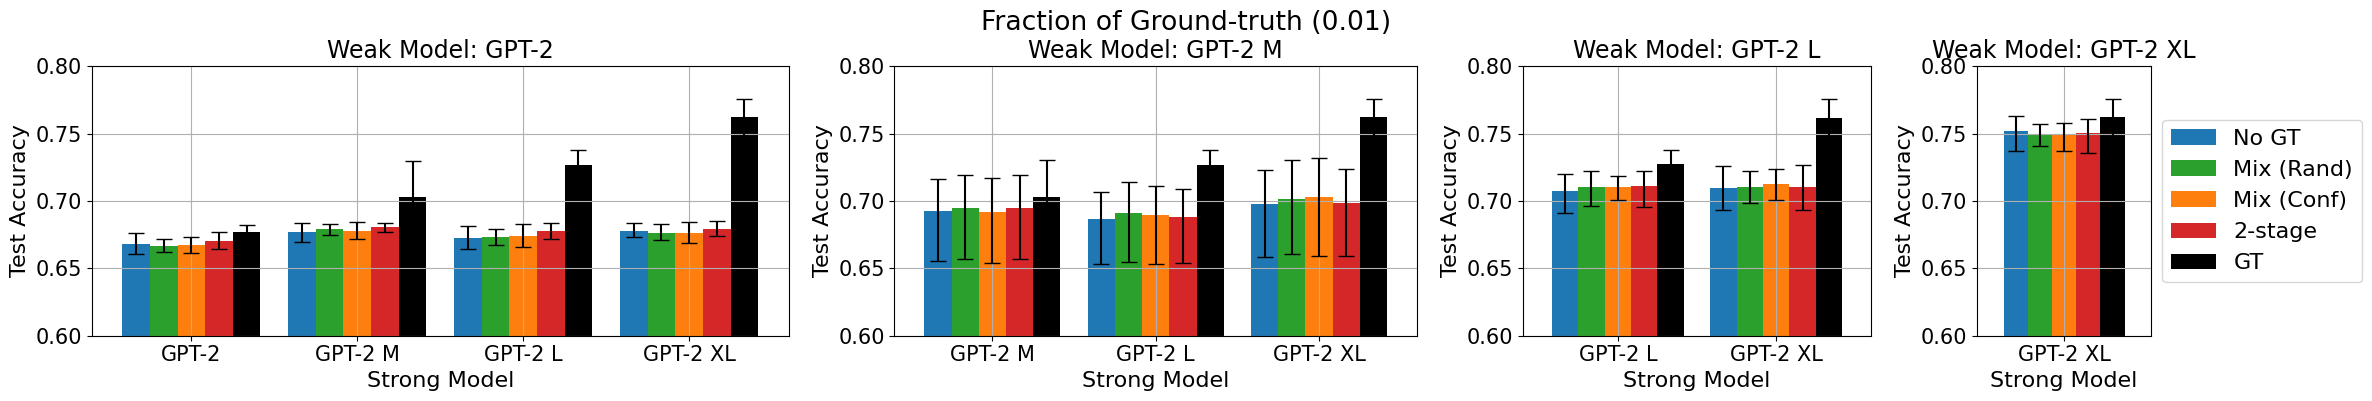

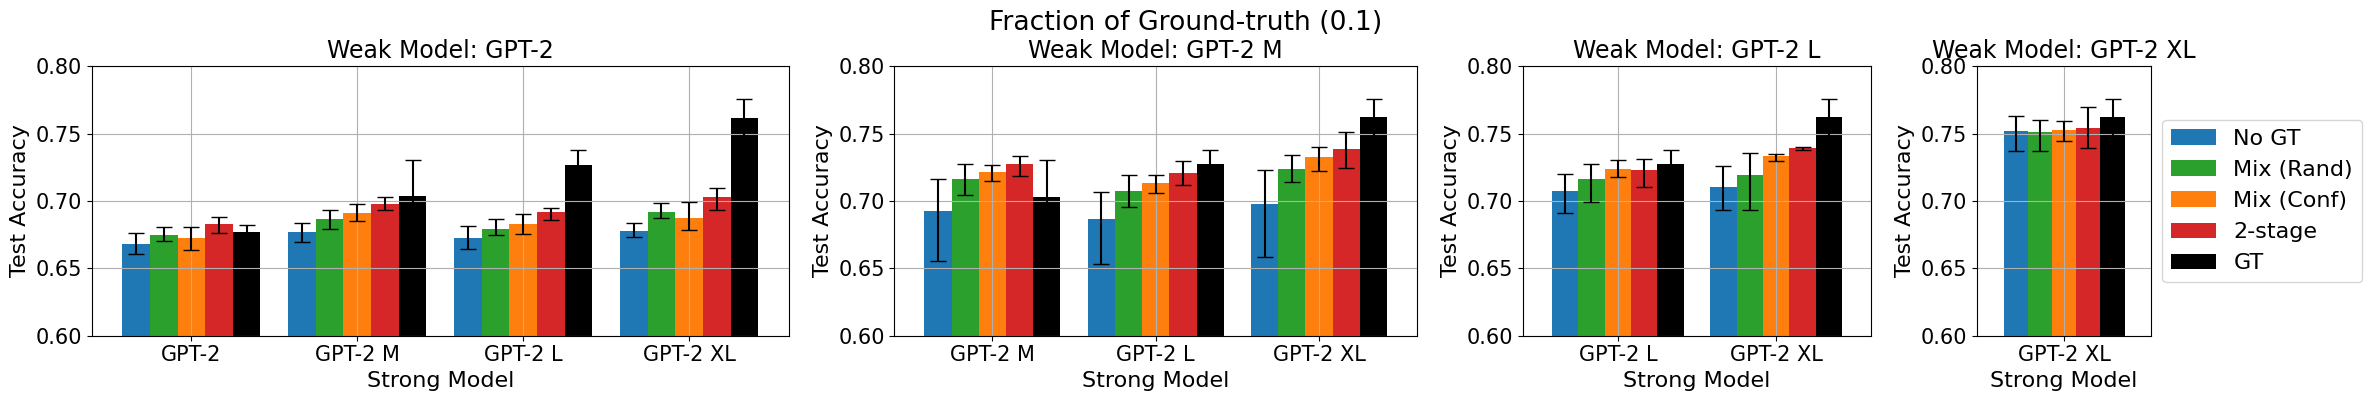

In [451]:
plot_test_acc_bars(all_results_df, 0.1, ceil_df, nogt_df)
plot_test_acc_bars(all_results_df[all_results_df.seed != 1], 0.1, ceil_df, nogt_df)

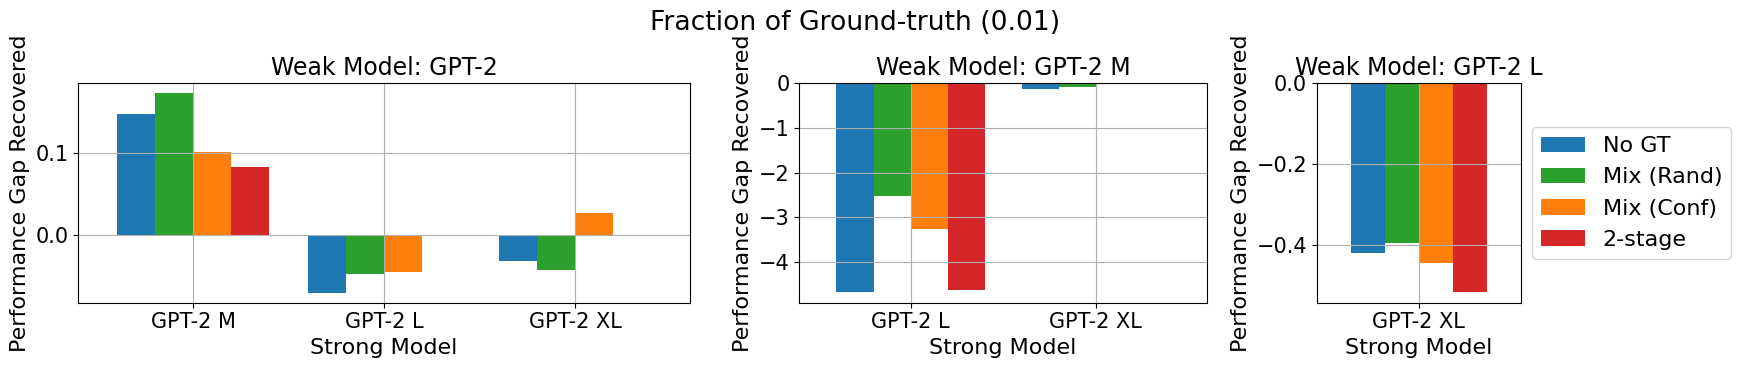

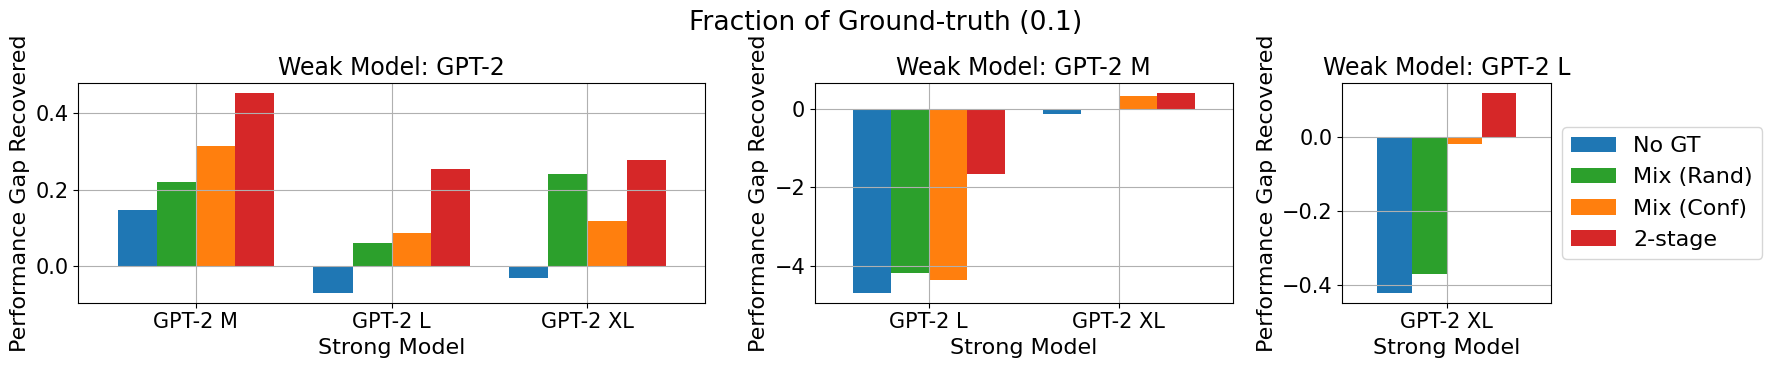

In [469]:
plot_pgr_bars(all_results_df, 0.01, ceil_df, nogt_df)
plot_pgr_bars(all_results_df[all_results_df.seed != 1], 0.1, ceil_df, nogt_df)

In [475]:
def plot_test_acc_or_pgr(ax, results_df, xs_dict, metric='accuracy', seed=None,
                         error="ci", ls="-", marker="o", color=None):
    weak_models = [None] if "weak_model_size" not in results_df.keys() else MODELS_TO_PLOT
    # results_df = get_results_from_folder(folder)

    if seed is not None:
        results_df = results_df[results_df.seed == seed]

    for wm_idx, wm in enumerate(weak_models):
        sms, means, lowers, uppers = [], [], [], []
        for sm_idx in range(wm_idx, len(MODELS_TO_PLOT)):
            sm = MODELS_TO_PLOT[sm_idx]
            if sm is None:
                continue

            df = results_df[results_df.model_size == sm]
            if "weak_model_size" in df.keys():
                df = df[df.weak_model_size == wm]

            if len(df) == 0:
                continue

            meas = df[metric].values
            mean = np.mean(meas)
            if error == "ci":
                mean, lower, upper = bootstrap_ci(meas)
            elif error == "se":
                se = np.std(meas) / np.sqrt(len(meas))
                lower, upper = mean - se, mean + se
            elif error is None:
                lower, upper = mean, mean
            else:
                raise ValueError()

            sms.append(sm)
            means.append(mean)
            uppers.append(upper)
            lowers.append(lower)

        means = np.array(means)
        lowers = np.array(lowers)
        uppers = np.array(uppers)

        color = COLOR_MAP[wm] if color is None else color
        xs = [xs_dict[sm] for sm in sms]
        ax.plot(xs, means, marker=marker, color=color, ms=7, ls=ls)
        ax.fill_between(xs, lowers, uppers, color=color, alpha=0.1)

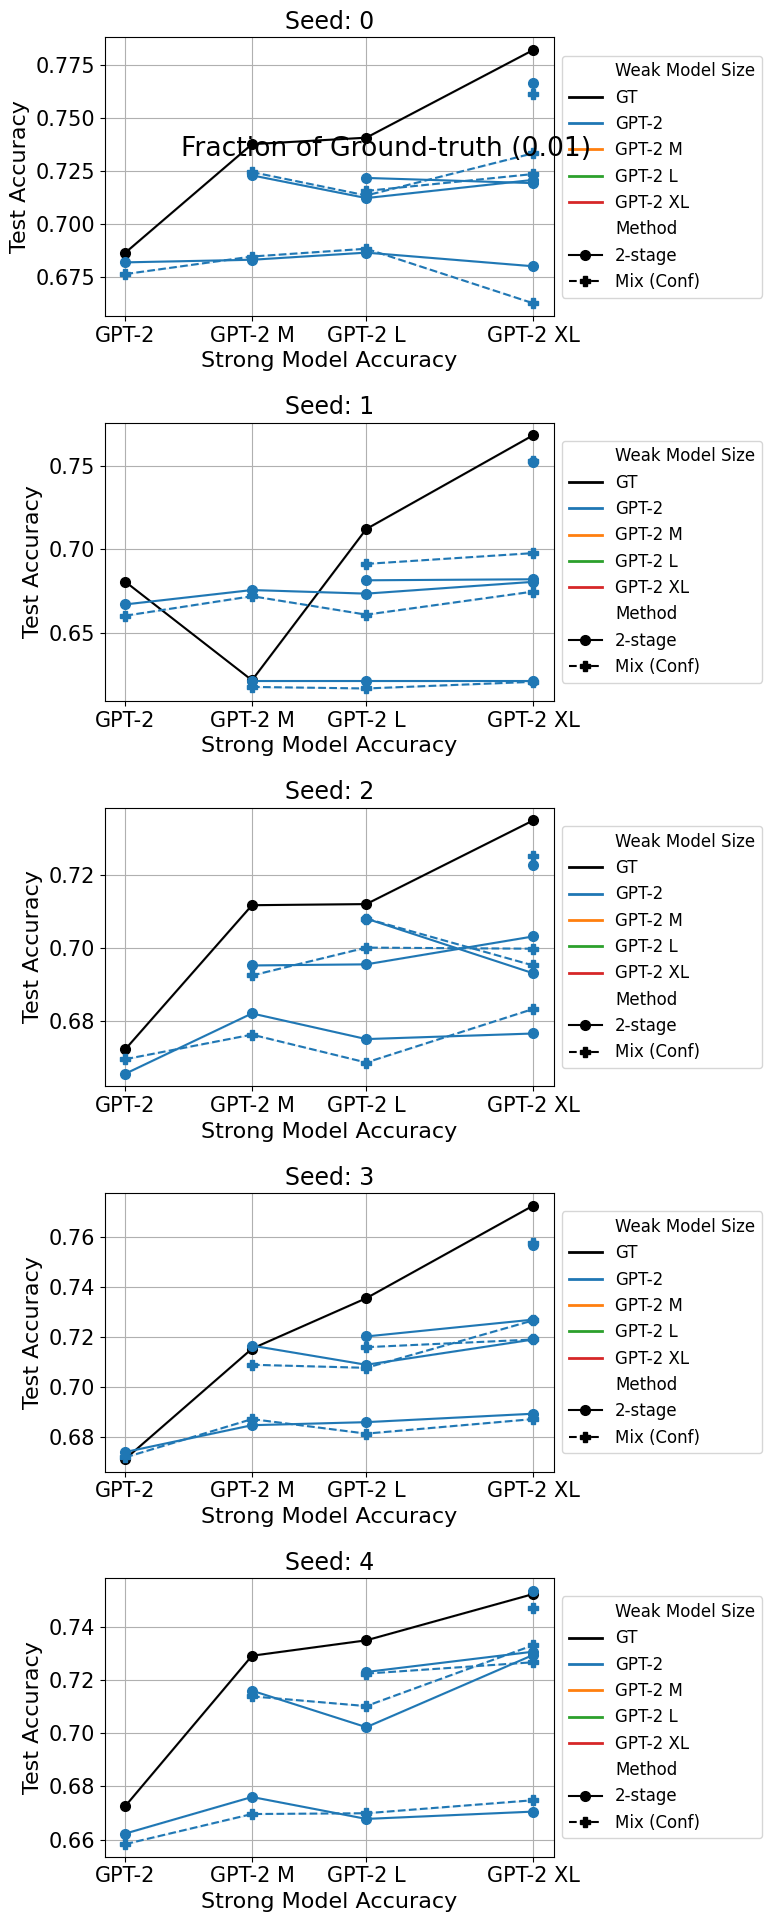

In [479]:
results_df = all_results_df
ceil_folder = "ceils"
baseline_method = "boolq_uniform_wmconf"
method = "boolq_weak_all_2_gt_smconf"
plot_all_seeds = True
error = "se"
gt_ratio = 0.01
plot_pgr = False


ratio_df = results_df[results_df.gt_ratio == gt_ratio]
baseline_df = nogt_df if baseline_method == "boolq_nogt" else ratio_df[ratio_df.method == baseline_method]
method_df = ratio_df[ratio_df.method == method]

xs = {}
for sm in MODELS_TO_PLOT:
    df = ceil_df[ceil_df.model_size == sm]
    accs = np.mean(df.accuracy.values)
    xs[sm] = accs

custom_lines = [
    Line2D([0], [0], color="white", lw=2, linestyle='-'),
    Line2D([0], [0], color="black", lw=2, linestyle='-'),
    Line2D([0], [0], color="tab:blue", lw=2, linestyle='-'),
    Line2D([0], [0], color="tab:orange", lw=2, linestyle='-'),
    Line2D([0], [0], color="tab:green", lw=2, linestyle='-'),
    Line2D([0], [0], color="tab:red", lw=2, linestyle='-'),
    Line2D([0], [0], color="white", lw=2, linestyle='-'),
    Line2D([0], [0], color="black", marker='o', ms=7, linestyle='-'),
    Line2D([0], [0], color="black", marker='P', ms=7, linestyle='--'),
]
custom_labels = [
    "Weak Model Size",
    "GT", "GPT-2", "GPT-2 M", "GPT-2 L", "GPT-2 XL", "Method",
    METHOD_LABEL_MAP[method],
    METHOD_LABEL_MAP[baseline_method]
]

if plot_all_seeds:
    seeds = np.unique(pd.concat([ceil_df, baseline_df, method_df]).seed.values)
    if plot_pgr:
        fig, axes = plt.subplots(len(seeds), 2, figsize=(12, 4 * len(seeds)))
    else:
        fig, axes = plt.subplots(len(seeds), 1, figsize=(8, 4 * len(seeds)), squeeze=False)

    for i, seed in enumerate(seeds):
        plot_test_acc_or_pgr(axes[i, 0], ceil_df, xs, seed=seed, error=error, ls='-', marker='o')
        plot_test_acc_or_pgr(axes[i, 0], baseline_df, xs, seed=seed, error=None, ls='--', marker='P')
        plot_test_acc_or_pgr(axes[i, 0], method_df, xs, seed=seed, error=error, ls='-', marker='o')

        axes[i, 0].set_title(f"Seed: {seed}")
        axes[i, 0].grid(True)
        axes[i, 0].set_ylabel("Test Accuracy")

        if plot_pgr:
            plot_test_acc_or_pgr(axes[i, 1], baseline_df, xs, metric='pgr', seed=seed, error=None, ls='--', marker='P')
            plot_test_acc_or_pgr(axes[i, 1], method_df, xs, metric='pgr', seed=seed, error=error, ls='-', marker='o')
            axes[i, 1].grid(True)
            axes[i, 1].set_ylabel("Performance Gap Recovered")

        axes[i, -1].legend(custom_lines, custom_labels, fontsize=12,
                          loc='center left', bbox_to_anchor=(1, 0.5))

else:
    if plot_pgr:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(8, 5))
        # fig, axes = plt.subplots(1, 1, figsize=(7, 5))
        axes = [axes]

    plot_test_acc_or_pgr(axes[0], ceil_df, xs, seed=None, error=error, ls='-', marker='o')
    plot_test_acc_or_pgr(axes[0], baseline_df, xs, seed=None, error=error, ls='--', marker='P')
    plot_test_acc_or_pgr(axes[0], method_df, xs, seed=None, error=error, ls='-', marker='o')

    axes[0].grid(True)
    axes[0].set_ylabel("Test Accuracy")

    if plot_pgr:
        plot_test_acc_or_pgr(axes[1], baseline_df, xs, metric='pgr', seed=None, error=None, ls='--', marker='P')
        plot_test_acc_or_pgr(axes[1], method_df, xs, metric='pgr', seed=None, error=error, ls='-', marker='o')
        axes[1].grid(True)
        axes[1].set_ylabel("Performance Gap Recovered")

    axes[-1].legend(custom_lines, custom_labels, fontsize=12,
                    loc='center left', bbox_to_anchor=(1, 0.5))

for axs in axes:
    if not isinstance(axs, np.ndarray):
        axs = [axs]
    for ax in axs:
        ax.set_xlabel("Strong Model Accuracy")
        ax.set_xticks(sorted(xs.values()))
        ax.set_xticklabels([MODELS_MAP[m] for m in MODELS_TO_PLOT])

fig.suptitle(f"Fraction of Ground-truth ({gt_ratio})", y=0.9)
plt.tight_layout()

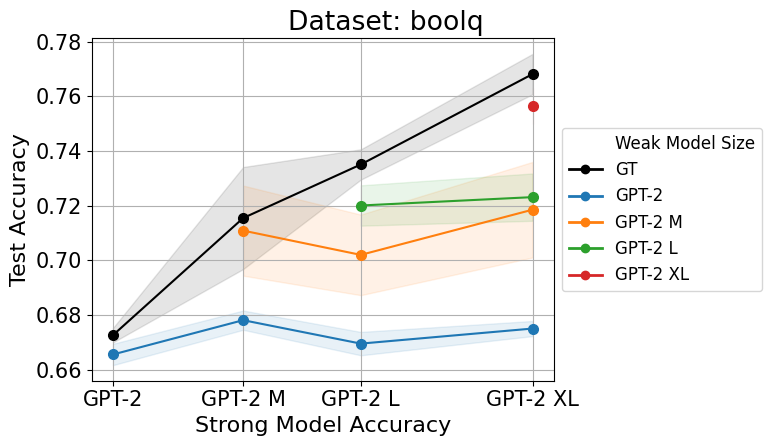

In [431]:
results_df = all_results_df
ceil_folder = "ceils"
method = "boolq_nogt"
plot_all_seeds = False
error = "se"
gt_ratio = 0.1
plot_pgr = False


ratio_df = results_df[results_df.gt_ratio == gt_ratio]
method_df = nogt_df if method == "boolq_nogt" else ratio_df[ratio_df.method == method]

xs = {}
for sm in MODELS_TO_PLOT:
    df = ceil_df[ceil_df.model_size == sm]
    accs = np.mean(df.accuracy.values)
    xs[sm] = accs

custom_lines = [
    Line2D([0], [0], color="white", lw=2, linestyle='-', marker='o'),
    Line2D([0], [0], color="black", lw=2, linestyle='-', marker='o'),
    Line2D([0], [0], color="tab:blue", lw=2, linestyle='-', marker='o'),
    Line2D([0], [0], color="tab:orange", lw=2, linestyle='-', marker='o'),
    Line2D([0], [0], color="tab:green", lw=2, linestyle='-', marker='o'),
    Line2D([0], [0], color="tab:red", lw=2, linestyle='-', marker='o'),
]
custom_labels = [
    "Weak Model Size",
    "GT", "GPT-2", "GPT-2 M", "GPT-2 L", "GPT-2 XL"
]

if plot_all_seeds:
    seeds = np.unique(pd.concat([ceil_df, method_df]).seed.values)
    if plot_pgr:
        fig, axes = plt.subplots(len(seeds), 2, figsize=(12, 4 * len(seeds)))
    else:
        fig, axes = plt.subplots(len(seeds), 1, figsize=(8, 4 * len(seeds)), squeeze=False)

    for i, seed in enumerate(seeds):
        plot_test_acc_or_pgr(axes[i, 0], ceil_df, xs, seed=seed, error=error, ls='-', marker='o')
        plot_test_acc_or_pgr(axes[i, 0], method_df, xs, seed=seed, error=error, ls='-', marker='o')

        axes[i, 0].set_title(f"Seed: {seed}")
        axes[i, 0].grid(True)
        axes[i, 0].set_ylabel("Test Accuracy")

        if plot_pgr:
            plot_test_acc_or_pgr(axes[i, 1], method_df, xs, metric='pgr', seed=seed, error=error, ls='-', marker='o')
            axes[i, 1].grid(True)
            axes[i, 1].set_ylabel("Performance Gap Recovered")

        axes[i, -1].legend(custom_lines, custom_labels, fontsize=12,
                          loc='center left', bbox_to_anchor=(1, 0.5))

else:
    if plot_pgr:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(8, 5))
        axes = [axes]

    plot_test_acc_or_pgr(axes[0], ceil_df, xs, seed=None, error=error, ls='-', marker='o')
    plot_test_acc_or_pgr(axes[0], method_df, xs, seed=None, error=error, ls='-', marker='o')

    axes[0].grid(True)
    axes[0].set_ylabel("Test Accuracy")

    if plot_pgr:
        plot_test_acc_or_pgr(axes[1], method_df, xs, metric='pgr', seed=None, error=error, ls='-', marker='o')
        axes[1].grid(True)
        axes[1].set_ylabel("Performance Gap Recovered")

    axes[-1].legend(custom_lines, custom_labels, fontsize=12,
                    loc='center left', bbox_to_anchor=(1, 0.5))

for axs in axes:
    if not isinstance(axs, np.ndarray):
        axs = [axs]
    for ax in axs:
        ax.set_xlabel("Strong Model Accuracy")
        ax.set_xticks(sorted(xs.values()))
        ax.set_xticklabels([MODELS_MAP[m] for m in MODELS_TO_PLOT])

fig.suptitle("Dataset: boolq", y=0.9)
plt.tight_layout()

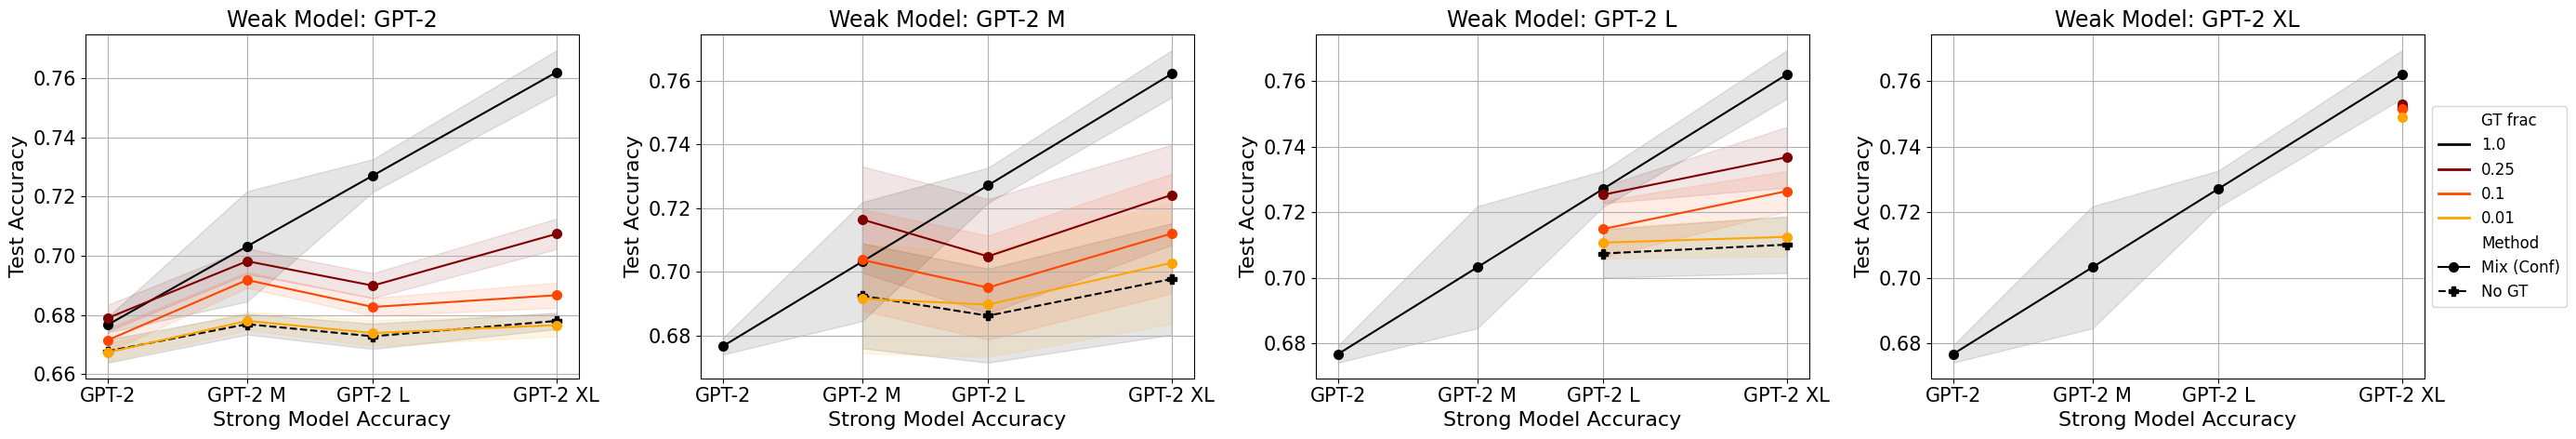

In [478]:
results_df = all_results_df
ceil_folder = "ceils"
method = "boolq_uniform_wmconf"
plot_all_seeds = False
error = "se"

cmap = plt.get_cmap('plasma')
ratio_color_map = {
    0.25: "maroon",
    0.1: "orangered",
    0.01: "orange",
}


baseline_df = nogt_df if baseline_method == "boolq_nogt" else results_df[results_df.method == baseline_method]
method_df = results_df[results_df.method == method]

xs = {}
for sm in MODELS_TO_PLOT:
    df = ceil_df[ceil_df.model_size == sm]
    accs = np.mean(df.accuracy.values)
    xs[sm] = accs

custom_lines = [
    Line2D([0], [0], color="white", lw=2, linestyle='-'),
    Line2D([0], [0], color="black", lw=2, linestyle='-'),
    Line2D([0], [0], color=ratio_color_map[0.25], lw=2, linestyle='-'),
    Line2D([0], [0], color=ratio_color_map[0.1], lw=2, linestyle='-'),
    Line2D([0], [0], color=ratio_color_map[0.01], lw=2, linestyle='-'),
    Line2D([0], [0], color="white", lw=2, linestyle='-'),
    Line2D([0], [0], color="black", marker='o', ms=7, linestyle='-'),
    Line2D([0], [0], color="black", marker='P', ms=7, linestyle='--'),
]
custom_labels = [
    "GT frac",
    "1.0", "0.25", "0.1", "0.01", "Method",
    METHOD_LABEL_MAP[method],
    METHOD_LABEL_MAP["boolq_nogt"]
]

if plot_all_seeds:
    seeds = np.unique(pd.concat([ceil_df, baseline_df, method_df]).seed.values)
    fig, axes = plt.subplots(len(seeds), 4, figsize=(8 * 4, 4 * len(seeds)), squeeze=False)

    for i, seed in enumerate(seeds):
        for j, wm in enumerate(MODELS_TO_PLOT):
            df = method_df[method_df.weak_model_size == wm]

            plot_test_acc_or_pgr(axes[i, j], ceil_df, xs, seed=seed, error=error, ls='-', marker='o')
            plot_test_acc_or_pgr(axes[i, j], nogt_df[nogt_df.weak_model_size == wm], xs, seed=seed, error=None, ls='--', marker='P')
            for gt_ratio in [0.25, 0.1, 0.01]:
                plot_test_acc_or_pgr(axes[i, j], df[np.isclose(df.gt_ratio, gt_ratio)], xs, seed=seed, error=error, ls='-', marker='o', color=ratio_color_map[gt_ratio])

            axes[i, j].set_title(f"Seed: {seed}")
            axes[i, j].grid(True)
            axes[i, j].set_ylabel("Test Accuracy")
            axes[i, j].set_title(f"Weak Model: {MODELS_MAP[wm]}")

        axes[i, -1].legend(custom_lines, custom_labels, fontsize=12,
                           loc='center left', bbox_to_anchor=(1, 0.5))

else:
    fig, axes = plt.subplots(1, 4, figsize=(7 * 4, 5))

    for j, wm in enumerate(MODELS_TO_PLOT):
        df = method_df[method_df.weak_model_size == wm]
        plot_test_acc_or_pgr(axes[j], ceil_df, xs, seed=None, error=error, ls='-', marker='o')
        plot_test_acc_or_pgr(axes[j], nogt_df[nogt_df.weak_model_size==wm], xs, seed=None, error=error, ls='--', marker='P', color='black')
        for gt_ratio in [0.25, 0.1, 0.01]:
            plot_test_acc_or_pgr(axes[j], df[np.isclose(df.gt_ratio, gt_ratio)], xs, seed=None, error=error, ls='-', marker='o', color=ratio_color_map[gt_ratio])

        axes[j].grid(True)
        axes[j].set_ylabel("Test Accuracy")
        axes[j].set_title(f"Weak Model: {MODELS_MAP[wm]}")

    axes[-1].legend(custom_lines, custom_labels, fontsize=12,
                    loc='center left', bbox_to_anchor=(1, 0.5))

for axs in axes:
    if not isinstance(axs, np.ndarray):
        axs = [axs]
    for ax in axs:
        ax.set_xlabel("Strong Model Accuracy")
        ax.set_xticks(sorted(xs.values()))
        ax.set_xticklabels([MODELS_MAP[m] for m in MODELS_TO_PLOT])

# fig.suptitle(f"Fraction of Ground-truth ({gt_ratio})", y=0.9)
plt.tight_layout()

In [687]:
RESULTS_PATH = "results/boolq_nogt"

PLOT_ALL_SEEDS = False
# Full sweep


In [688]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from IPython.display import display

import os
import glob
import json

In [1217]:
# folders = ["ceils", "boolq_nogt"]
# folders = ["ceils", "boolq_uniform_wmconf"]
# folders = ["ceils", "boolq_uniform_wmconf_gr01"]
# folders = ["ceils", "boolq_uniform_wmconf_gr001"]
# folders = ["ceils", "boolq_uniform_rand"]
# folders = ["ceils", "boolq_uniform_rand_gr01"]
# folders = ["ceils", "boolq_uniform_rand_gr001"]
# folders = ["ceils", "boolq_weak_all_2_gt_smconf_sbs16_slm1"]
# folders = ["ceils", "boolq_weak_all_2_gt_smconf_sbs16_slm07"]
# folders = ["ceils", "boolq_weak_all_2_gt_smconf_gr01_sbs8_slm1"]
# folders = ["ceils", "boolq_weak_all_2_gt_smconf_gr01_sbs8_slm05"]
folders = ["ceils", "boolq_weak_all_2_gt_smconf_gr01_sbs8_slm05_balsub"]
# folders = ["ceils", "boolq_weak_all_2_gt_smconf_gr01_sbs8_slm01"]
# folders = ["ceils", "boolq_weak_all_2_gt_smconf_lp_gt025_sbs16_slm1"]
df = pd.concat([get_results_from_folder(f) for f in folders])

Dataset: boolq (seed: None)


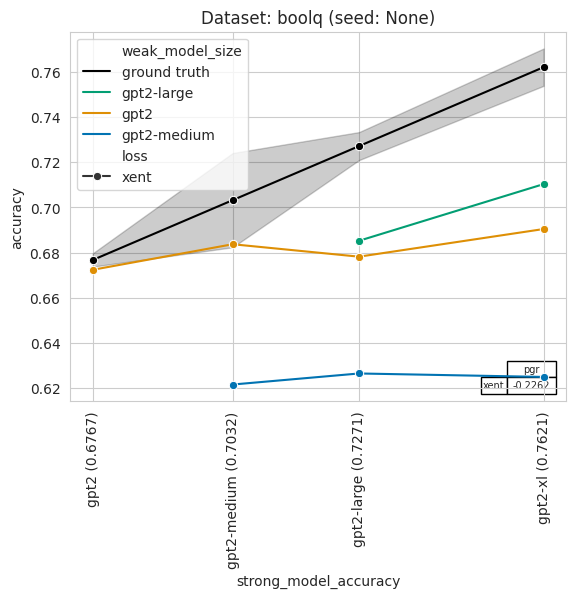

In [1218]:
datasets = df.ds_name.unique()
for dataset in datasets:
    cur_df = df[(df.ds_name == dataset)].copy()
    base_accuracies = cur_df[cur_df['weak_model_size'].isna()].groupby('model_size').agg({'accuracy': 'mean', 'seed': 'count'}).sort_values('accuracy')
    base_accuracy_lookup = base_accuracies['accuracy'].to_dict()
    base_accuracies = base_accuracies.reset_index()

    cur_df['strong_model_accuracy'] = cur_df['model_size'].apply(lambda x: base_accuracy_lookup[x])
    cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_accuracy'] = cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_size'].apply(lambda x: base_accuracy_lookup[x])

    # Exclude cases where the weak model is better than the strong model from PGR calculation.
    valid_pgr_index = (
        (~cur_df['weak_model_size'].isna()) &
        (cur_df['weak_model_size'] != cur_df['model_size']) &
        (cur_df['strong_model_accuracy'] > cur_df['weak_model_accuracy'])
    )
    cur_df.loc[valid_pgr_index, 'pgr'] = (cur_df.loc[valid_pgr_index, 'accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy']) / (cur_df.loc[valid_pgr_index, 'strong_model_accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy'])

    cur_df.loc[cur_df['weak_model_size'].isna(), "weak_model_size"] = "ground truth"

    for seed in [None] + (sorted(cur_df['seed'].unique().tolist()) if PLOT_ALL_SEEDS else []):
        plot_df = cur_df.copy().sort_values(['strong_model_accuracy']).sort_values(['loss'], ascending=False)
        if seed is not None:
            plot_df = plot_df[plot_df['seed'] == seed]

        print(f"Dataset: {dataset} (seed: {seed})")

        pgr_results = plot_df[~plot_df['pgr'].isna()].groupby(['loss']).aggregate({"pgr": "median"})

        palette = sns.color_palette('colorblind', n_colors=len(plot_df['weak_model_size'].unique()) - 1)
        color_dict = {model: ("black" if model == 'ground truth' else palette.pop()) for model in plot_df['weak_model_size'].unique()}

        sns.lineplot(data=plot_df, x='strong_model_accuracy', y='accuracy', hue='weak_model_size', style='loss', markers=True, palette=color_dict, errorbar='se')
        pd.plotting.table(plt.gca(), pgr_results.round(4), loc='lower right', colWidths=[0.1, 0.1], cellLoc='center', rowLoc='center')
        plt.xticks(ticks=base_accuracies['accuracy'], labels=[f"{e} ({base_accuracy_lookup[e]:.4f})" for e in base_accuracies['model_size']], rotation=90)
        plt.title(f"Dataset: {dataset} (seed: {seed})")
        plt.legend(loc='upper left')
        suffix = ""
        if seed is not None:
            suffix = f"_{seed}"
        plt.savefig(f"{dataset.replace('/', '-')}{suffix}.png", dpi=300, bbox_inches='tight')
        plt.show()

In [806]:
ceils_path = "results/ceils"
records = []
for result_filename in glob.glob(os.path.join(ceils_path, "**/results.pkl"), recursive=True):
    config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
    config = json.load(open(config_file, "r"))

    if "warmup_steps" not in config:
        config["warmup_steps"] = 0
    if "end_mult" not in config:
        config["end_mult"] = 0.0

    with open(result_filename, "rb") as f:
        results = pickle.load(f)

    data = config.copy()
    data["valid_acc"] = results["avg_acc_inference"]
    data["test_acc"] = results["avg_acc_test"]
    records.append(data)

In [807]:
df = pd.DataFrame(records)

In [86]:
df

,batch_size,max_ctx,ds_name,loss,n_docs,n_test_docs,model_size,lr,optim,epochs,seed,train_with_dropout,linear_probe,lr_schedule,eval_every,warmup_steps,end_mult,valid_acc,test_acc
0,32,1024,boolq,xent,20000,10000,gpt2,0.00005,adam,2,0,False,False,cosine_anneal,1000000,0,0.0,0.645312,0.650046
1,32,1024,boolq,xent,20000,10000,gpt2-large,0.00001,adam,2,0,False,False,cosine_anneal,1000000,0,0.1,0.751379,0.747323
2,32,1024,boolq,xent,20000,10000,gpt2-large,0.00001,adam,2,0,False,False,cosine_anneal,1000000,30,0.0,0.729105,0.737229
3,32,1024,boolq,xent,20000,10000,gpt2-xl,0.00001,adam,2,0,False,False,cosine_anneal,1000000,0,0.0,0.774077,0.775467
4,32,1024,boolq,xent,20000,10000,gpt2-xl,0.00001,adam,2,0,False,False,cosine_anneal,1000000,30,0.0,0.765592,0.771184
5,32,1024,boolq,xent,20000,10000,gpt2-large,0.00001,adam,2,0,False,False,cosine_anneal,1000000,0,0.0,0.740136,0.743347
6,32,1024,boolq,xent,20000,10000,gpt2-xl,0.00001,adam,2,0,False,False,cosine_anneal,1000000,30,0.1,0.780441,0.779749
7,32,1024,boolq,xent,20000,10000,gpt2-medium,0.00005,adam,2,0,False,False,cosine_anneal,1000000,30,0.1,0.736954,0.733252
8,32,1024,boolq,xent,20000,10000,gpt2-xl,0.00001,adam,2,0,False,False,cosine_anneal,1000000,0,0.1,0.782987,0.784032
9,32,1024,boolq,xent,20000,10000,gpt2-large,0.00001,adam,2,0,False,False,cosine_anneal,1000000,30,0.1,0.744378,0.740593


gpt2 0.6453118370810352 0.6815867628341111
gpt2-medium 0.6883750530335172 0.7369537547730165
gpt2-large 0.7401357658039881 0.7443784471786169
gpt2-xl 0.7740772168010183 0.7804412388629614


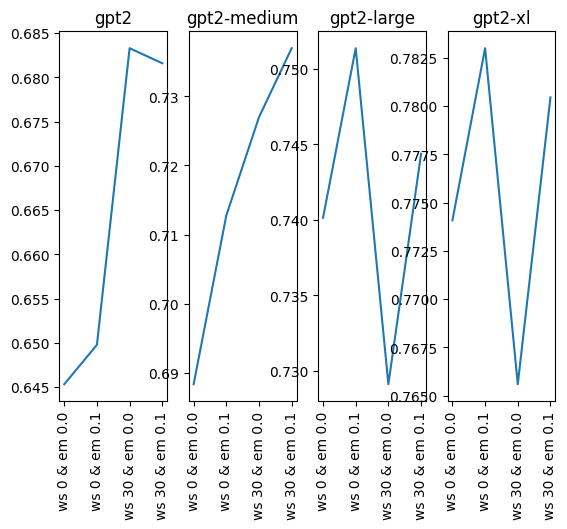

In [93]:
fig, axs = plt.subplots(1, 4)

for i, model in enumerate(["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]):
    xticks, ys = [], []
    for warmup_steps in [0, 30]:
        for end_mult in [0.0, 0.1]:
            row = df[
                (df.model_size == model)
                & (df.warmup_steps == warmup_steps)
                & (df.end_mult == end_mult)
            ]
            xticks.append(f"ws {warmup_steps} & em {end_mult}")
            ys.append(row.valid_acc.squeeze())
    axs[i].plot(np.arange(len(ys)), ys)
    axs[i].set_title(model)
    axs[i].set_xticks(np.arange(len(ys)))
    axs[i].set_xticklabels(xticks, rotation=90)

    print(model, ys[0], ys[-1])

In [48]:
row.valid_acc.squeeze()

0.6453118370810352

# Dataset debug

In [265]:
def set_to_groundtruth(ex, idx, indices):
    if idx in indices:
        ex['soft_label'] = [1 - float(ex["gt_label"]), float(ex["gt_label"])]
        ex['use_gt'] = True
    else:
        ex['use_gt'] = False
    return ex


def maybe_balance_dataset(ds, indices, balance_method):
    subset = ds.select(indices)

    # Note that selecting ground-truth examples to be class-balanced is not really
    # possible unless we know the label in advance.
    # There are two options:
    # 1) Use all selected ground-truth examples even if they are class-imbalanced.
    # 2) Use a subset of ground-truth examples such that the classes are balanced.
    # 3) Up-sample the smaller class (this will result in duplicate data).
    if balance_method == "subset":
        class0_idxs = np.where(np.array(subset['gt_label']) == 0)[0]
        class1_idxs = np.where(np.array(subset['gt_label']) == 1)[0]
        min_len = min(len(class0_idxs), len(class1_idxs))
        class0_idxs = class0_idxs[:min_len]
        class1_idxs = class1_idxs[:min_len]
        all_idxs = list(class0_idxs) + list(class1_idxs)
        indices = [indices[idx] for idx in all_idxs]

        assert sum(ds.select(indices)['gt_label']) == len(indices) // 2
    elif balance_method == "upsample":
        class0_idxs = np.where(np.array(subset['gt_label']) == 0)[0]
        class1_idxs = np.where(np.array(subset['gt_label']) == 1)[0]
        if len(class0_idxs) > len(class1_idxs):
            extra = len(class0_idxs) - len(class1_idxs)
            class1_idxs = list(class1_idxs) + list(np.random.choice(class1_idxs, extra))
        elif len(class0_idxs) < len(class1_idxs):
            extra = len(class1_idxs) - len(class0_idxs)
            class0_idxs = list(class0_idxs) + list(np.random.choice(class0_idxs, extra))
        all_idxs = list(class0_idxs) + list(class1_idxs)
        indices = [indices[idx] for idx in all_idxs]

        assert sum(ds.select(indices)['gt_label']) == len(indices) // 2

    # Shuffle gt_indices.
    np.random.shuffle(indices)

    return indices


def get_first_round_datasets(
    weak_labels_path,
    gt_ratio=0.0,
    balance_method=None,
    dset_type="uniform",
    gt_selection_strategy="random",
    choose_all_weak=False,
    seed=0
):
    np.random.seed(seed)

    ds = load_from_disk(weak_labels_path)

    if dset_type == "weak" and choose_all_weak:
        return ds, []

    if gt_ratio > 0.0:
        num_train = len(ds)
        num_gt = min(num_train, int(gt_ratio * num_train))

        if gt_selection_strategy == "wm_conf":
            gt_indices = np.argsort(np.stack(ds['soft_label']).max(-1))[: num_gt]
        elif gt_selection_strategy == "random":
            gt_indices = np.random.choice(num_train, num_gt, replace=False)
        else:
            raise ValueError()

        gt_indices = maybe_balance_dataset(ds, gt_indices, balance_method)

        # Set datapoints corresponding to gt_indices to have soft_label be ground-truth values.
        ds = ds.map(partial(set_to_groundtruth, indices=gt_indices), with_indices=True)
        if dset_type == "uniform":
            pass
        elif dset_type == "gt":
            # Select only ground-truth datapoints.
            ds = ds.select(list(gt_indices))
        elif dset_type == "weak" and not choose_all_weak:
            # Select only weak datapoints.
            non_gt_indices = list(i for i in range(num_train) if i not in gt_indices)
            ds = ds.select(list(non_gt_indices))
        else:
            raise ValueError()
    else:
        gt_indices = []

    return ds, gt_indices


def get_second_round_datasets(
    weak_labels_path,
    gt_ratio,
    dset_type,
    balance_method=None,
    gt_selection_strategy="random",
    strong_labels_path=None,
    choose_all_weak=False,
    seed=0
):
    np.random.seed(seed)

    ds = load_from_disk(weak_labels_path)

    if dset_type == "weak" and choose_all_weak:
        return ds, []

    num_train = len(ds)
    num_gt = min(num_train, int(gt_ratio * num_train))
    if gt_selection_strategy == "wm_conf":
        gt_indices = np.argsort(np.stack(ds['soft_label']).max(-1))[: num_gt]
    elif gt_selection_strategy == "random":
        gt_indices = np.random.choice(num_train, num_gt, replace=False)
    elif gt_selection_strategy == "sm_conf":
        sm_ds = load_from_disk(strong_labels_path)
        gt_indices = np.argsort(np.stack(sm_ds['soft_label']).max(-1))[: num_gt]
    else:
        raise ValueError()

    print(len(gt_indices))
    gt_indices = maybe_balance_dataset(ds, gt_indices, balance_method)
    print(len(gt_indices))

    if dset_type == "gt":
        ds = ds.map(partial(set_to_groundtruth, indices=gt_indices), with_indices=True)
        ds = ds.select(list(gt_indices))
    elif dset_type == "weak" and not choose_all_weak:
        # Select only weak datapoints.
        non_gt_indices = list(i for i in range(len(ds)) if i not in gt_indices)
        ds = ds.select(list(non_gt_indices))
    else:
        raise ValueError()

    return ds, gt_indices


In [255]:
weak_labels_path = "old_results/ceils/bs=32-dn=boolq-em=0.1-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0-ws=30/weak_labels"

In [267]:
# gt conf of weak -> weak conf of weak.
first_ds, first_gt_indices = get_first_round_datasets(
    weak_labels_path, gt_ratio=0.01, balance_method="upsample",
    dset_type="gt", gt_selection_strategy="wm_conf"
)
second_ds, second_gt_indices = get_second_round_datasets(
    weak_labels_path, gt_ratio=0.01, dset_type="weak", balance_method="upsample",
    gt_selection_strategy="wm_conf"
)

Map:   0%|          | 0/4714 [00:00<?, ? examples/s]

47
48


In [25]:
warmup_iters = 10
end_mult = 0.1
nsteps = 294

def cosine_lr_schedule_fn(it):
    # linear warmup for warmup_iters steps
    if it < warmup_iters:
        return it / warmup_iters
    # After warmup, cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (nsteps - warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return coeff * (1 - end_mult) + end_mult

def constant_lr_schedule_fn(step):
    # linear warmup for warmup_iters steps
    if step < warmup_iters:
        return step / warmup_iters
    return 1

In [277]:
d = {}
d.pop('a', None)

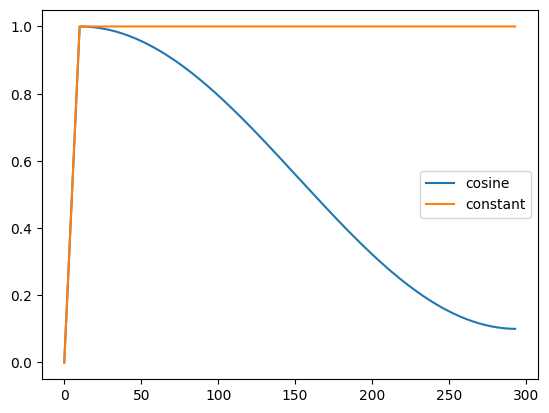

In [26]:
x = range(nsteps)
cosine_lrs = list(cosine_lr_schedule_fn(it) for it in x)
constant_lrs = list(constant_lr_schedule_fn(it) for it in x)
plt.plot(x, cosine_lrs, label='cosine')
plt.plot(x, constant_lrs, label='constant')
plt.legend()

In [52]:
exp_path = "results/default/bs=32-dn=boolq-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0"

In [53]:
with open(os.path.join(exp_path, "results.pkl"), "rb") as f:
    results = pickle.load(f)

In [54]:
results

{'avg_acc_test': 0.6567757724074641,
 'avg_acc_inference': 0.6527365294866355,
 'test_results': Dataset({
     features: ['txt', 'input_ids', 'gt_label', 'hard_label', 'acc', 'logits', 'soft_label'],
     num_rows: 3269
 }),
 'inference_results': Dataset({
     features: ['txt', 'input_ids', 'gt_label', 'hard_label', 'acc', 'logits', 'soft_label'],
     num_rows: 4714
 })}

In [76]:
ds = results['inference_results'].remove_columns(['input_ids'])

In [81]:
ds[0]

{'txt': "Passage: Mistrials are generally not covered by the double jeopardy clause. If a judge dismisses the case or concludes the trial without deciding the facts in the defendant's favor (for example, by dismissing the case on procedural grounds), the case is a mistrial and may normally be retried. Furthermore, if a jury cannot reach a verdict, the judge may declare a mistrial and order a retrial as was addressed in United States v. Josef Perez, 22 U.S. 579 (1824). When the defendant moves for a mistrial, there is no bar to retrial, even if the prosecutor or judge caused the error that forms the basis of the motion. An exception exists, however, where the prosecutor or judge has acted in bad faith. In Oregon v. Kennedy, 456 U.S. 667 (1982), the Supreme Court held that ``only where the governmental conduct in question is intended to 'goad' the defendant into moving for a mistrial may a defendant raise the bar of double jeopardy to a second trial after having succeeded in aborting the

In [108]:
idxs

array([ 884, 3901, 2746, ..., 2744, 1287, 1285])

In [124]:
use_gt_for_low_wm_conf = True
gt_ratio = 0.1


num_gt = min(len(ds), int(gt_ratio * len(ds)))
if use_gt_for_low_wm_conf:
    gt_indices = np.argsort(np.stack(ds['soft_label']).max(-1))[: num_gt]
else:
    gt_indices = np.random.choice(len(ds), num_gt, replace=False)

def set_to_groundtruth(ex, idx, indices):
    if idx in indices:
        ex['soft_label'] = [1 - float(ex["gt_label"]), float(ex["gt_label"])]
    return ex

new_ds = ds.map(partial(set_to_groundtruth, indices=gt_indices), with_indices=True)

Map:   0%|          | 0/4714 [00:00<?, ? examples/s]

In [125]:
gt_indices[0]

884

In [126]:
new_ds[884]

{'txt': 'Passage: Bees with barbed stingers can often sting other insects without harming themselves. Queen honeybees and bees of many other species, including bumblebees and many solitary bees, have smoother stingers with smaller barbs, and can sting mammals repeatedly.\nQuestion: does a bee always die after it stings',
 'gt_label': 0,
 'hard_label': 1,
 'acc': False,
 'logits': [-0.00019423989579081535, 0.0001942003145813942],
 'soft_label': [1.0, 0.0]}

In [69]:
boolq_dataset = load_dataset('boolq', seed=0, split_sizes=dict(train=20000, test=10000))

Warning boolq has less than 20000 docs, using all: Index 19999 out of range for dataset of size 9427.
Warning boolq has less than 10000 docs, using all: Index 9999 out of range for dataset of size 3270.


In [70]:
split_data = boolq_dataset['train'].train_test_split(test_size=0.5, seed=0)
train1_ds, train2_ds = split_data["train"], split_data["test"]

In [71]:
def test_map(ex, idx):
    return {'haha': ex['hard_label'], 'idx': idx}

new_df = train1_ds.map(test_map, with_indices=True)

In [72]:
len(new_df)

4713

In [73]:
new_df[0]

{'question': 'is there a sequel to batman versus superman',
 'answer': True,
 'passage': "Batman v Superman: Dawn of Justice premiered at the Auditorio Nacional in Mexico City on March 19, 2016, and was released in the United States on March 25, 2016 in 2D, 3D, IMAX 3D, 4DX, premium large formats, and 70 mm prints by Warner Bros. Pictures. Following a strong debut that set new box office records, the film experienced a historic drop in its second weekend and never recovered. Despite turning a profit, it was deemed a box office disappointment and received generally unfavorable reviews from critics for its tone, screenplay, and pacing, though some praised its visual style and acting performances. An extended cut dubbed the ``Ultimate Edition'', which features 31 minutes of additional footage, was released digitally on June 28, 2016, and on Blu-ray on July 19, 2016. A direct sequel, titled Justice League, was released in November 2017.",
 'txt': "Passage: Batman v Superman: Dawn of Justic

# Estimate accuracy

In [383]:
from train_simple import WEAK_MODEL_CONFIG_NAMES, get_config_foldername

In [ ]:
    results_path = os.path.join('results', folder)

    glob_str = os.path.join(results_path, "**/second/results_summary.json")
    if not glob.glob(glob_str):
        glob_str = os.path.join(results_path, "**/first/results_summary.json")

    records = []
    for result_filename in glob.glob(glob_str):
        config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
        config = json.load(open(config_file, "r"))

        record = {
            "seed": config["seed"],
            "model_size": config["model_size"],
        }
        if "weak_model_size" in config:
            record["weak_model_size"] = config["weak_model"]["model_size"]
        if "gt_ratio" in config:
            record["gt_ratio"] = config["gt_ratio"]
        record.update(json.load(open(result_filename)))
        records.append(record)
    return pd.DataFrame(records)

In [321]:
def get_dataset(seed, n_docs, n_test_docs):
    # Load dataset
    dataset = load_dataset("boolq", seed=seed, split_sizes=dict(train=n_docs, test=n_test_docs))

    # Split the training dataset in half
    train_dataset, test_ds = dataset["train"], dataset["test"]
    split_data = train_dataset.train_test_split(test_size=0.5, seed=seed)
    train1_ds, train2_ds = split_data["train"], split_data["test"]
    return train2_ds

In [407]:
folder = "boolq_uniform_wmconf"

def get_weak_record_df(folder):
    results_path = os.path.join('results', folder)
    glob_str = os.path.join(results_path, "**/second/results_summary.json")
    if not glob.glob(glob_str):
        glob_str = os.path.join(results_path, "**/first/results_summary.json")

    records = []
    for result_filename in glob.glob(glob_str):
        config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
        config = json.load(open(config_file, "r"))

        seed = config["seed"]

        weak_model_config_name = WEAK_MODEL_CONFIG_NAMES[config["ds_name"]][config["weak_model_size"]].format(seed=config["seed"])
        weak_labels_path = (
            "results" + "/" + "ceils" + "/" + weak_model_config_name + "/first" + "/weak_labels"
        )
        weak_ds = load_from_disk(weak_labels_path)
        # ds = get_dataset(config["seed"], config["n_docs"], config["n_test_docs"])
        # assert np.array_equal([int(label) for label in ds['answer']], weak_ds['gt_label'])

        gt_indices = config["gt_indices"]
        gt_ds = weak_ds.select(gt_indices)
        acc = np.mean(gt_ds['gt_label'] == np.argmax(gt_ds['soft_label'], axis=1))
        wrongs = np.sum(gt_ds['gt_label'] != np.argmax(gt_ds['soft_label'], axis=1))
        total_wrongs = np.sum(weak_ds['gt_label'] != np.argmax(weak_ds['soft_label'], axis=1))

        record = {
            "seed": config["seed"],
            "gt_ratio": config["gt_ratio"],
            "weak_model_size": config["weak_model_size"],
            "acc": acc,
            "wrongs": wrongs,
            "total_wrongs": total_wrongs,
        }
        records.append(record)
    record_df = pd.DataFrame(records)
    return record_df

gpt2 0.6811544991511036 0.2464386529641331
gpt2-medium 0.7096774193548386 0.2446984631050403
gpt2-large 0.7307300509337861 0.24742300096049413
gpt2-xl 0.7626485568760611 0.2504427703996287
gpt2 0.5455008488964346 0.35175864683918956
gpt2-medium 0.5582342954159593 0.3794868178175346
gpt2-large 0.5634974533106961 0.40157125181900666
gpt2-xl 0.5920203735144313 0.43063640428715555


(0.2354015660459345, 0.4399333013462613)

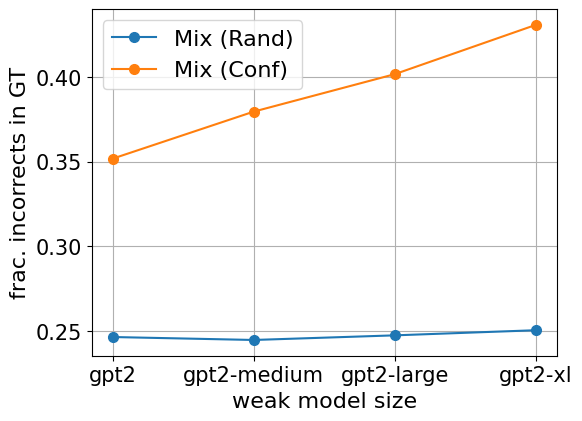

In [425]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

for folder in ["boolq_uniform_rand", "boolq_uniform_wmconf"]:
    record_df = get_weak_record_df(folder)
    ys = []
    for model in MODELS_TO_PLOT:
        df = record_df[record_df['weak_model_size'] == model]
        wrong_ratios = df.wrongs.values / df.total_wrongs.values
        print(model, df.acc.mean(), np.mean(wrong_ratios))
        ys.append(np.mean(wrong_ratios))
    ax.plot(np.arange(len(ys)), ys, marker='o', ms='7', label=METHOD_LABEL_MAP[folder])
    ax.set_xticks(np.arange(len(ys)))
    ax.set_xticklabels(MODELS_TO_PLOT)
ax.legend()
ax.set_xlabel("weak model size")
ax.set_ylabel("frac. incorrects in GT")
ax.grid(True)
ax.set_ylim(0.2354015660459345, 0.4399333013462613)

In [426]:
folder = "boolq_weak_all_2_gt_smconf_sbs16_slm1"

results_path = os.path.join('results', folder)
glob_str = os.path.join(results_path, "**/second/results_summary.json")
if not glob.glob(glob_str):
    glob_str = os.path.join(results_path, "**/first/results_summary.json")

records = []
for result_filename in glob.glob(glob_str):
    base_path = '/'.join(result_filename.split('/')[:-2])

    config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
    config = json.load(open(config_file, "r"))

    seed = config["seed"]

    weak_model_config_name = WEAK_MODEL_CONFIG_NAMES[config["ds_name"]][config["weak_model_size"]].format(seed=config["seed"])
    weak_labels_path = (
        "results" + "/" + "ceils" + "/" + weak_model_config_name + "/first" + "/weak_labels"
    )
    weak_ds = load_from_disk(weak_labels_path)

    pretrained_config = config.copy()
    for key in list(pretrained_config.keys()):
        if key.startswith("second_"):
            pretrained_config.pop(key)
    pretrained_config.pop("gt_indices", None)
    pretrained_config.pop("weak_model", None)
    pretrained_config.pop("gt_ratio", None)
    pretrained_config_name = get_config_foldername(pretrained_config)
    pretrained_path = os.path.join("results", "boolq_nogt", pretrained_config_name, "first", "strong_labels")
    strong_ds = load_from_disk(pretrained_path)
    gt_indices = np.argsort(np.stack(strong_ds['soft_label']).max(-1))[: len(config['gt_indices'])]

    # gt_indices = config["gt_indices"]
    gt_ds = weak_ds.select(gt_indices)
    acc = np.mean(gt_ds['gt_label'] == np.argmax(gt_ds['soft_label'], axis=1))
    wrongs = np.sum(gt_ds['gt_label'] != np.argmax(gt_ds['soft_label'], axis=1))
    total_wrongs = np.sum(weak_ds['gt_label'] != np.argmax(weak_ds['soft_label'], axis=1))

    record = {
        "seed": config["seed"],
        "gt_ratio": config["gt_ratio"],
        "weak_model_size": config["weak_model_size"],
        "model_size": config["model_size"],
        "acc": acc,
        "wrongs": wrongs,
        "total_wrongs": total_wrongs,
    }
    records.append(record)
record_df = pd.DataFrame(records)

In [427]:
for model in MODELS_TO_PLOT:
    df = record_df[record_df['model_size'] == model]
    wrong_ratios = df.wrongs.values / df.total_wrongs.values
    print(model, df.acc.mean(), np.mean(wrong_ratios))

gpt2 0.5580645161290324 0.34192053202439743
gpt2-medium 0.5577249575551784 0.35999498819372167
gpt2-large 0.5711941143180532 0.36278096672462323
gpt2-xl 0.576528013582343 0.3782615548421575


gpt2 0.5580645161290324 0.34192053202439743
gpt2-medium 0.5577249575551784 0.35999498819372167
gpt2-large 0.5711941143180532 0.36278096672462323
gpt2-xl 0.576528013582343 0.3782615548421575


(0.2354015660459345, 0.4399333013462613)

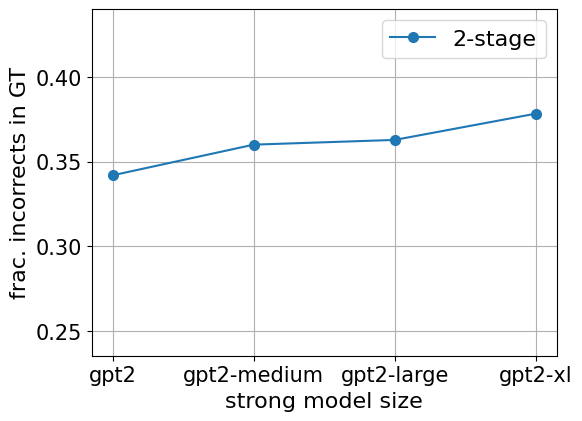

In [429]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

for folder in ["boolq_weak_all_2_gt_smconf"]:
    ys = []
    for model in MODELS_TO_PLOT:
        df = record_df[record_df['model_size'] == model]
        wrong_ratios = df.wrongs.values / df.total_wrongs.values
        print(model, df.acc.mean(), np.mean(wrong_ratios))
        ys.append(np.mean(wrong_ratios))
    ax.plot(np.arange(len(ys)), ys, marker='o', ms='7', label=METHOD_LABEL_MAP[folder])
    ax.set_xticks(np.arange(len(ys)))
    ax.set_xticklabels(MODELS_TO_PLOT)
ax.legend()
ax.set_xlabel("strong model size")
ax.set_ylabel("frac. incorrects in GT")
ax.grid(True)
ax.set_ylim(0.2354015660459345, 0.4399333013462613)